In [71]:
import netCDF4 as nc
import numpy as np
from matplotlib import pylab as plt
import gsw
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
from numpy import ma

In [72]:
%%latex
Ce code est décomposé en 2 parties différentes. 
La deuxième partie permet de tracer les courants géostrophiques à une profondeur donnée, calculés à partir des équations du vent thermique.
Les deux parties sont indépendantes pour permettre au code d'être moins complexe si l'utilisateur·ice est seulement intéressé·e par une des deux parties.


<IPython.core.display.Latex object>

In [73]:
# Paramètres de la simulation
pathname='/home/brout/Documents/UBO/M2/PO1/ncfiles/'  # Path where all the different files are located. To extract
                                                      # ncfiles, change their name with the pattern 'property.nc'
                                                    
lonmin, lonmax=-80,10      # Longitudes min et max qui nous intéressent
latmin, latmax=-60,60      # Latitudes min et max qui nous intéressent

g=9.81                     # Gravité
rho_0=1030                 # Densité moyenne de l'océan
T=3600*24                  # Période de rotation de la Terre
omega=2*np.pi/T            # Vitesse angulaire de la Terre
Rt=6.4E6                   # Rayon terrestre

lon_transect=-25.5         # Longitude à laquelle tracer les sections.
time_index=0               # Choix de l'indice de temps auquel tracer les différents graphes. Ici, 
                           # time_index=0 puisqu'il n'y a qu'un seul temps de disponible. Le code a cependant été
                           # fait pour s'adapter à une base de données où t varie.

y_ticks=np.linspace(latmin,latmax,7) # Choisir les ticks à afficher pour la latitude
z_ticks=np.linspace(-5000,0,6)       # Choisir les ticks à afficher pour la profondeur


depth_vplot=0.0            # Depth chosen to plot geostrophic velocity, choose an existing one in the data base
depth_ref=1500             # Depth of the assumed level of no motion.



In [74]:
# Importation des fichiers nc.

file=pathname+'temperature.nc'
temp=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')

file=pathname+'salinity.nc'
sal=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')

file=pathname+'nitrates.nc'
nit=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')

file=pathname+'phosphate.nc'
phos=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')

file=pathname+'oxygen.nc'
ox=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')

file=pathname+'silicate.nc'
sil=nc.Dataset(file,'r',datamodel='NETCDF_CLASSIC',disk_format='hdf5')


In [75]:
# Arrays of properties at every latitude, longitude and depth
lon=temp['lon'][:]
lat=temp['lat'][:]
depth=temp['depth'][:]
temperature0=temp['t_an'][:] 
salinity0=sal['s_an'][:]
nitrates0=nit['n_an'][:]
phosphates0=phos['p_an'][:]
oxygen0=ox['o_an'][:]
silicate0=sil['i_an'][:]


In [76]:
# Fermeture des fichiers pour alléger
nc.Dataset.close(temp)
nc.Dataset.close(sal)
nc.Dataset.close(nit)
nc.Dataset.close(phos)
nc.Dataset.close(ox)
nc.Dataset.close(sil)

## Part 1 : transects

In [49]:
# Zoom sur la zone géographique à laquelle on s'intéresse
longitude=lon[(lon>lonmin) & (lon<lonmax)]
latitude=lat[(lat>latmin) & (lat<latmax)]
Longitude,Latitude=np.meshgrid(longitude,latitude)


#Ces tableaux sont de dimension 4 et correspondent aux différentes propriétés en fonction de x,y,z et t. 
#La première dimension correspond au temps, la deuxième à la profondeur, la troisième à la latitude, 
# et la quatrième à la longitude

temperature=temperature0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
salinity=salinity0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
nitrates=nitrates0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
phosphates=phosphates0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
oxygen=oxygen0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
silicate=silicate0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]



In [50]:
# Calcul du champ de pression à toutes les latitudes et toutes les profondeurs

pressure=np.zeros((np.size(depth),np.size(latitude)))
for i in range (np.size(latitude)):                                     
    pressure[:,i]=gsw.p_from_z(-depth,latitude[i])


In [51]:
#Définition des différents tableaux 2D (profondeur et latitude) nécessaires au tracé des sections.

transect_index=np.where(longitude==lon_transect)   #transect_index est l'indice de la longitude choisie pour les plots

temperature_transect=temperature[time_index,:,:,transect_index][0,0]
absolute_salinity_transect=gsw.SA_from_SP(salinity[time_index,:,:,transect_index],pressure,lon_transect,latitude)[0,0]
potential_temperature_transect=gsw.pt_from_t(absolute_salinity_transect,temperature[time_index,:,:,transect_index],pressure,0)[0,0]
oxygen_transect=oxygen[time_index,:,:,transect_index][0,0]
nitrates_transect=nitrates[time_index,:,:,transect_index][0,0]
silicate_transect=silicate[time_index,:,:,transect_index][0,0]
phosphates_transect=phosphates[time_index,:,:,transect_index][0,0]
potential_density_transect=gsw.pot_rho_t_exact(absolute_salinity_transect,temperature_transect,pressure,0)-1000 # To get the density anomaly


In [52]:
# Ces deux fonctions permettent d'afficher les chaînes de caractère correspondant
# aux ticks choisis au début du programme

def tickstring_lat(y_ticks):
    tick=[]
    for i in range(len(y_ticks)):
        if y_ticks[i]<0 and y_ticks[i]%1==0:
            tick.append(str(abs(int(y_ticks[i])))+'°S')
        elif y_ticks[i]>0 and y_ticks[i]%1==0:
            tick.append(str(int(y_ticks[i]))+'°N')
        elif y_ticks[i]<0:
            tick.append(str(abs(y_ticks[i]))+'°S')
        elif y_ticks[i]>0:
            tick.append(str(abs(y_ticks[i]))+'°N')
        else:
            tick.append('0°')
    return(tick)

def tickstring_depth(z_ticks):
    tick=[]
    for i in range(len(z_ticks)):
        if depth[i]%1==0.0:
            tick.append(str(int(z_ticks[i])))
        else:
            tick.append(str(z_ticks[i]))
    return(tick)

y_strings,z_strings=tickstring_lat(y_ticks),tickstring_depth(z_ticks)



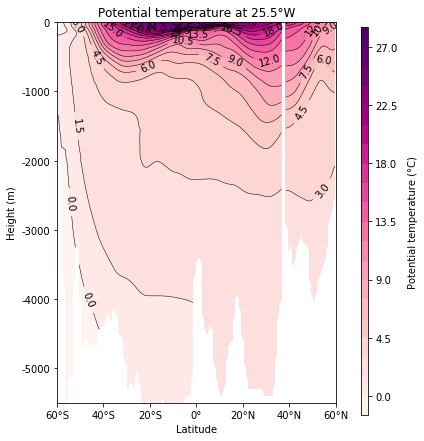

In [53]:
# Potential_temperature transect. This part of the code can be copied and pasted for every physical quantity.
# The user has just to change the physical scale in grandeur, the unit, and the field used to plot.
colormap='RdPu'                        # Choisir une colormap pour le plot


X,Y=np.meshgrid(latitude,-depth)       # Grille pour tracer les contours de température conservative
fig,ax=plt.subplots(figsize=(5,7))     
grandeur='Potential temperature'       # String for the title of the plot
unit='(°C)'                            # Unit of the physical scale plotted
if lon_transect<0:                     # In the original array, western longitudes are negative, eastern longitudes are positive
    card='W'
elif lon_transect>0:
    card='E'
else:
    card=''
title=grandeur + ' at ' + str(abs(lon_transect)) + '°' + card


#Contours
CS=ax.contour(X,Y,potential_temperature_transect,colors='k',linewidths=0.5,levels=25) # Change data input here
plt.clabel(CS, fontsize=10, inline=True, fmt = '%0.1f')                  
mappable=ax.contourf(X,Y,potential_temperature_transect,levels=25,cmap=colormap)      # Change data input here
ax.set_xlabel('Latitude')
ax.set_ylabel('Height (m)')
ax.set_title(title)

# Set ticks
plt.xticks(y_ticks,y_strings)
plt.yticks(z_ticks,z_strings)

# Colorbar
wi,hi  = 0.02,0.77                                             # Colorbar dimensions
xc,yc  = 0.97,0.1                                              # Colorbar position
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='vertical')
cb.set_label(grandeur + ' ' + unit,fontsize=10,labelpad=10)
cb.ax.tick_params(labelsize=10)


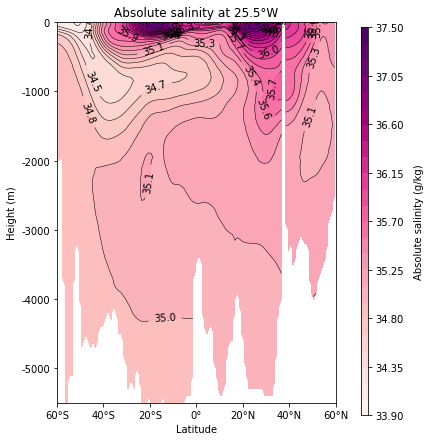

In [54]:
# Absolute salinity transect. For more comments, go to potential temperature transect.
colormap='RdPu'


X,Y=np.meshgrid(latitude,-depth)
fig,ax=plt.subplots(figsize=(5,7))
grandeur='Absolute salinity'          # Change physical quantity here
unit='(g/kg)'                         # Change unit here
if lon_transect<0:
    card='W'
elif lon_transect>0:
    card='E'
else:
    card=''
title=grandeur + ' at ' + str(abs(lon_transect)) + '°' + card


CS=ax.contour(X,Y,absolute_salinity_transect,colors='k',linewidths=0.5,levels=25) # Change data input here
plt.clabel(CS, fontsize=10, inline=True, fmt = '%0.1f')
mappable=ax.contourf(X,Y,absolute_salinity_transect,levels=25,cmap=colormap)      # Change data input here
ax.set_xlabel('Latitude')
ax.set_ylabel('Height (m)')
ax.set_title(title)

# Set ticks
plt.xticks(y_ticks,y_strings)
plt.yticks(z_ticks,z_strings)

# Colorbar
wi,hi  = 0.02,0.77
xc,yc  = 0.97,0.1
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='vertical')
cb.set_label(grandeur + ' ' + unit,fontsize=10,labelpad=10)
cb.ax.tick_params(labelsize=10)

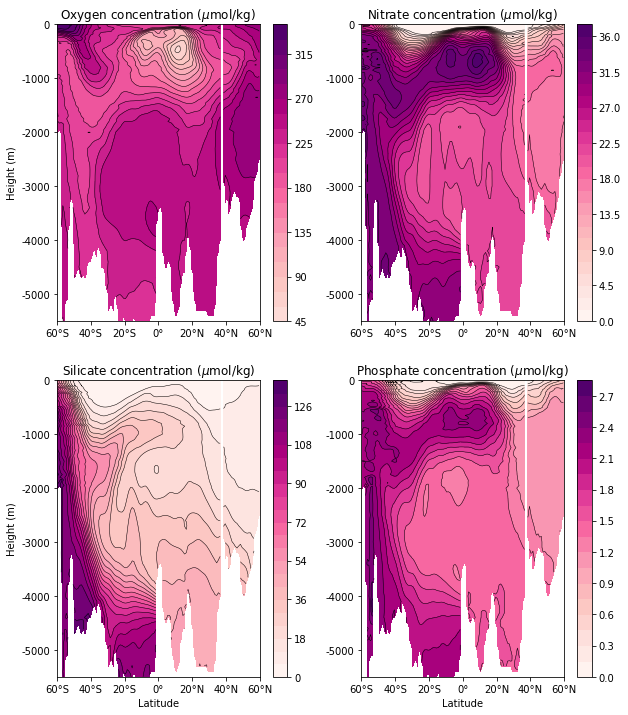

In [55]:
# Oxygen, phosphates, silicates and nitrates transects in one plot. 
colormap='RdPu'


X,Y=np.meshgrid(latitude,-depth)
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,12))

#Set titles of subplots
title1,title2,title3,title4=r'Oxygen concentration ($\mu$mol/kg)',r'Nitrate concentration ($\mu$mol/kg)',r'Silicate concentration ($\mu$mol/kg)',r'Phosphate concentration ($\mu$mol/kg)'

# Oxygen
CS1=ax1.contour(X,Y,oxygen_transect,colors='k',linewidths=0.5,levels=25)   # Change data input here
mappable1=ax1.contourf(X,Y,oxygen_transect,levels=25,cmap=colormap,vmin=0) # Change data entry here
ax1.set_ylabel('Height (m)')
ax1.set_title(title1)

# Nitrates
CS2=ax2.contour(X,Y,nitrates_transect,colors='k',linewidths=0.5,levels=25)   # Change data input here
mappable2=ax2.contourf(X,Y,nitrates_transect,levels=25,cmap=colormap,vmin=0) # Change data input here
ax2.set_title(title2)

# Silicate
CS3=ax3.contour(X,Y,silicate_transect,colors='k',linewidths=0.5,levels=25)  # Change data input here
mappable3=ax3.contourf(X,Y,silicate_transect,levels=25,cmap=colormap,vmin=0)# Change data input here
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Height (m)')
ax3.set_title(title3)

# Phosphates
CS4=ax4.contour(X,Y,phosphates_transect,colors='k',linewidths=0.5,levels=25)  # Change data input here
mappable4=ax4.contourf(X,Y,phosphates_transect,levels=25,cmap=colormap,vmin=0)# Change data input here
ax4.set_xlabel('Latitude')
ax4.set_title(title4)


# Set ticks
plt.sca(ax1)
plt.xticks(y_ticks,y_strings)
plt.yticks(z_ticks,z_strings)


plt.sca(ax2)
plt.xticks(y_ticks,y_strings)
plt.yticks(z_ticks,z_strings)


plt.sca(ax3)
plt.xticks(y_ticks,y_strings)
plt.yticks(z_ticks,z_strings)


plt.sca(ax4)
plt.xticks(y_ticks,y_strings)
plt.yticks(z_ticks,z_strings)


# Colorbar
fig.colorbar(mappable1, ax=ax1)
fig.colorbar(mappable2, ax=ax2)
fig.colorbar(mappable3, ax=ax3)
fig.colorbar(mappable4, ax=ax4)

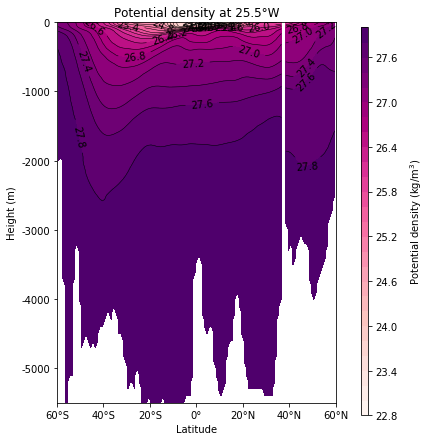

In [56]:
# Potential density transect. For more comments, go to potential temperature transect.
colormap='RdPu'


X,Y=np.meshgrid(latitude,-depth)
fig,ax=plt.subplots(figsize=(5,7))
grandeur='Potential density'             # Change physical quantity here
unit=r'(kg/m$^3$)'                       # Change unit here
if lon_transect<0:
    card='W'
elif lon_transect>0:
    card='E'
else:
    card=''
title=grandeur + ' at ' + str(abs(lon_transect)) + '°' + card

CS=ax.contour(X,Y,potential_density_transect,colors='k',linewidths=0.5,levels=25) # Change data input here
plt.clabel(CS, fontsize=10, inline=True, fmt = '%0.1f')
mappable=ax.contourf(X,Y,potential_density_transect,levels=25,cmap=colormap)  # Change data input here
ax.set_xlabel('Latitude')
ax.set_ylabel('Height (m)')
ax.set_title(title)

# Set ticks
plt.xticks(y_ticks,y_strings)
plt.yticks(z_ticks,z_strings)

# Colorbar
wi,hi  = 0.02,0.77
xc,yc  = 0.97,0.1
cax    = fig.add_axes([xc,yc,wi,hi])
cb     = plt.colorbar(mappable,cax,orientation='vertical')
cb.set_label(grandeur + ' ' + unit,fontsize=10,labelpad=10)
cb.ax.tick_params(labelsize=10)

/home/brout/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 's'


Text(34.8, 26.1, 'ESW')

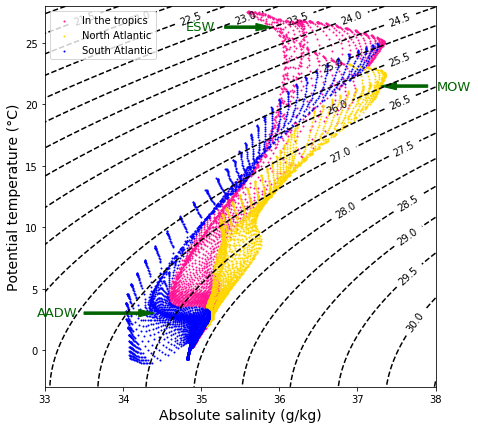

In [57]:
# T-S diagram of the transect. Les mesures sont regroupés en 3 types de latitude différents : 
# Atlantique Nord subtropical, Sud subtropical, et entre les tropiques

# Between the tropics
salinity_trop=np.reshape(absolute_salinity_transect[:,abs(latitude)<20],np.size(absolute_salinity_transect[:,abs(latitude)<20]))
potential_temperature_trop=np.reshape(potential_temperature_transect[:,abs(latitude)<20],np.size(potential_temperature_transect[:,abs(latitude)<20]))

# North Atlantic
salinity_north_atlantic=np.reshape(absolute_salinity_transect[:,latitude>20],np.size(absolute_salinity_transect[:,latitude>20]))
potential_temperature_north_atlantic=np.reshape(potential_temperature_transect[:,latitude>20],np.size(potential_temperature_transect[:,latitude>20]))

# South Atlantic
salinity_south_atlantic=np.reshape(absolute_salinity_transect[:,latitude<-20],np.size(absolute_salinity_transect[:,latitude<-20]))
potential_temperature_south_atlantic=np.reshape(potential_temperature_transect[:,latitude<-20],np.size(potential_temperature_transect[:,latitude<-20]))

# Isopycnes
fig,ax=plt.subplots(figsize=(7,7))
S=np.linspace(33,38,100)
T=np.linspace(-3,28,100)
X_SA,Y_CT=np.meshgrid(S,T)
rho_grid=gsw.rho(X_SA,Y_CT,0)-1000    
CS=ax.contour(X_SA,Y_CT,rho_grid,linestyles='dashed',s=1,levels=20,colors='k')


# T-S points
ax.scatter(salinity_trop,potential_temperature_trop,s=1,c='deeppink',label='In the tropics')
ax.scatter(salinity_north_atlantic,potential_temperature_north_atlantic,s=1,c='gold',label='North Atlantic')
ax.scatter(salinity_south_atlantic,potential_temperature_south_atlantic,s=1,c='b',label='South Atlantic')
ax.set_ylim(-3)
ax.set_xlabel('Absolute salinity (g/kg)',fontsize=14)
ax.set_ylabel('Potential temperature (°C)',fontsize=14)
plt.legend()
plt.clabel(CS, fontsize=10, inline=1, fmt = '%0.1f')
plt.savefig('T-S_diagram')

# Water masses
#Antarctic Deep Water
ax.arrow(33.5,3,0.7,0,width=.2,color='darkgreen',head_length=0.2)
ax.text(32.9,2.8,'AADW',color='darkgreen',fontsize=13)

#Mediterranean outflow water
ax.arrow(37.9,21.5,-0.4,0,width=.2,color='darkgreen',head_length=0.2)
ax.text(38.02,21.2,'MOW',color='darkgreen',fontsize=13)

# Equator surface water
ax.arrow(35.3,26.3,0.4,0,width=.2,color='darkgreen',head_length=0.2)
ax.text(34.8,26.1,'ESW',color='darkgreen',fontsize=13)

# Part 2 : geostrophic currents

In [58]:
%%latex
Dans cette partie, la stratégie adoptée pour calculer toutes sortes de grandeurs est de transformer tous les champs en tableaux à 4 dimensions.
L'intérêt est de faciliter les notations, puisque les champs mathématiques et tableaux numpy se correspondront parfaitement.


<IPython.core.display.Latex object>

In [80]:
%%latex
Pour calculer le courant géostrophique à une longitude, une latitude, et une profondeur donnée, on se sert des équations du vent thermique, que l'on intègre sur toute la colonne d'eau
\begin{equation*}
    \partial_zv=-\frac{g}{\rho_0 f}\partial_x \rho\\
    \partial_zu=\frac{g}{\rho_0f}\partial_y \rho
\end{equation*}
Il nous faut connaître pour ce faire une profondeur pour laquelle les courants sont nuls (level of no motion), puis intégrer ces EDP sur toute la colonne d'eau. Une fois que le procédé est fait pour une colonne d'eau, il suffit de le reproduire à chaque point de la zone à laquelle on s'intéresse.
Il convient maintenant de détailler le processus d'intégration.
\begin{equation*}
\end{equation*}
\begin{equation*}
\text{Calcul de l'intégrande}
\end{equation*}

\begin{equation*}
dv=-\frac{g}{\rho_0 f}(\partial_x \rho) dz\\
du=\frac{g}{\rho_0f}(\partial_y \rho) dz
\end{equation*}

$g, \rho_0$ et $f$ sont faciles à calculer. Pour le gradient méridien de densité, nous allons l'approximer par $\frac{\sigma(x,y+\Delta y,z) - \sigma(x,y,z)}{\Delta y}$ où $\Delta y$ est la distance séparant deux colonnes d'eau voisines. Pour le gradient zonal de densité, c'est le même procédé appliqué à la variable $x$.
\begin{equation*}
\end{equation*}
\begin{equation*}
\text{Calcul de l'intégrale}
\end{equation*}

Pour connaître le courant géostrophique $u(z)$ à l'altitude $z$, on intègre les équations précédentes, en appelant $z_0$ la profondeur où les courants sont nuls.
      
\begin{equation*}
\int_0^{v(z)}dv = \int_{z_0}^z -\frac{g}{\rho_0f}(\partial_x \rho)dz    \\
\int_0^{u(z)}du = \int_{z_0}^z \frac{g}{\rho_0f}(\partial_y \rho)dz
\end{equation*}

Pour intégrer informatiquement, on utilise la même astuce qu'en TD. La variable $z$ est discrétisée (ici, en 102 éléments), et nous appelons $k$ les indices de la liste des profondeurs pour plus de clarté (k=0 correspond donc à la surface).

Pour chaque indice $k$, nous considérons la valeur de $\partial_y\rho_k(x,y)$ (ou $\partial_x\rho_k(x,y)$) comme constante sur une couche comprise entre les altitudes $\frac{z_{k-1}+z_k}{2}$ et $\frac{z_k+z_{k+1}}{2}$. 

Pour calculer l'intégrale, nous partons donc de la couche de courants nuls k_0, et sommons les valeurs de l'intégrande sur chaque couche en les multipliant à chaque fois par l'épaisseur de la couche, c'est-à-dire $\Delta z_k=\frac{z_{k-1}-z_{k+1}}{2}$
.
\begin{equation*}
u_{k}=\sum_{i=k_0}^k \frac{g}{\rho_0f}\partial_y \rho \Delta z_k\\
\end{equation*}

Cette formule est valable si $k>k_0$, c'est-à-dire si on intègre en-dessous de la couche de courants nuls. Si on intègre au-dessus de cette couche, l'indice de cette somme diminuera de 1 à chaque itération. Informatiquement, nous procéderons donc à une somme de la droite vers la gauche du tableau.
Il est aussi possible d'écrire notre somme mathématiquement comme suit :
\begin{equation*}
u_k=\sum_{i=1}^k \frac{g}{\rho_0f}(\partial_y\sigma)_{k_0-i}\Delta z_{k_0-i}\\
\end{equation*}
Il est impossible d'évaluer par cette méthode le gradient méridien de densité à la limite Nord du bassin ou le gradient zonal de densité à la limite Est du bassin.
Si $\rho_k$ est un tableau de dimension $(N_{lat},N_{lon})$, $u_k$ sera de dimension $(N_{lat}-1,N_{lon})$, et $v_k$ de dimension $(N_{lat},N_{lon}-1)$.
Pour tracer ces vitesses, nous allons donc faire la moyenne entre deux vitesses consécutives, et tracer la vitesse résultante sur une grille de dimension $(N_{lat}-1,N_{lon}-1)$.
Ceci est résumé par le schéma tracé dans la cellule d'après. Le point jaune représente la nouvelle grille, les points roses, les vitesses méridionales et zonales calculées par cette méthode, et les points bleus les points de mesure.

      


<IPython.core.display.Latex object>

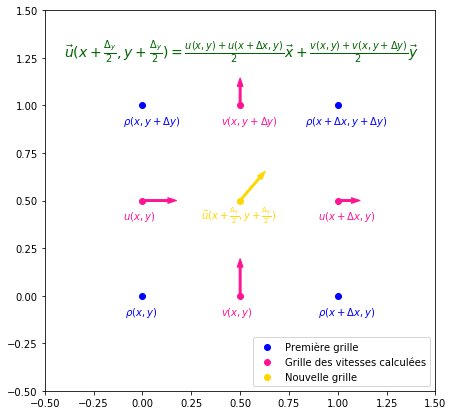

In [60]:
fig,ax=plt.subplots(figsize=(7,7))
ax.scatter([0,0,1,1],[0,1,0,1],c='b',label='Première grille')
ax.scatter([0.5,0.5,0,1],[0,1,0.5,0.5],c='deeppink',label='Grille des vitesses calculées')
ax.scatter([0.5],[0.5],c='gold',label='Nouvelle grille')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.5,1.5)
ax.text(-0.09,-0.1,r'$\rho(x,y)$',c='b')
ax.text(-0.1,0.9,r'$\rho(x,y+\Delta y)$',c='b')
ax.text(0.9,-0.1,r'$\rho(x+\Delta x,y)$',c='b')
ax.text(0.83,0.9,r'$\rho(x+\Delta x, y + \Delta y)$',c='b')
ax.text(0.4,-0.1,r'$v(x,y)$',c='deeppink')
ax.text(0.4,0.9,r'$v(x,y+\Delta y)$',c='deeppink')
ax.text(-0.1,0.4,r'$u(x,y)$',c='deeppink')
ax.text(0.9,0.4,r'$u(x+\Delta x,y)$',c='deeppink')
ax.text(0.3,0.4,r'$\vec{u}(x+\frac{\Delta_y}{2},y+\frac{\Delta_y}{2})$',c='gold')
ax.arrow(0.5,0.5,0.1,0.12,width=0.01,color='gold')
ax.text(-0.4,1.25,r'$\vec{u}(x+\frac{\Delta_y}{2},y+\frac{\Delta_y}{2})=\frac{u(x,y)+u(x+\Delta x,y)}{2}\vec{x}+\frac{v(x,y)+v(x,y+\Delta y)}{2}\vec{y}$',fontsize=14,c='darkgreen')
ax.arrow(0.5,1,0,0.1,width=0.01,color='deeppink')
ax.arrow(0.5,0,0,0.15,width=0.01,color='deeppink')
ax.arrow(0,0.5,0.13,0,width=0.01,color='deeppink')
ax.arrow(1,0.5,0.07,0,width=0.01,color='deeppink')
plt.legend(loc="lower right")

In [81]:
# Zoom sur la zone géographique à laquelle on s'intéresse
longitude=lon[(lon>lonmin) & (lon<lonmax)]
latitude=lat[(lat>latmin) & (lat<latmax)]
Longitude,Latitude=np.meshgrid(longitude,latitude)

#Ces tableaux sont de dimension 4 et correspondent aux différentes propriétés en fonction de x,y,z et t. 
#La première dimension correspond au temps, la deuxième à la profondeur, la troisième à la latitude, 
# et la quatrième à la longitude

temperature=temperature0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
salinity=salinity0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
nitrates=nitrates0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
phosphates=phosphates0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
oxygen=oxygen0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]
silicate=silicate0[:,:,(lat>latmin) & (lat<latmax),:][:,:,:,(lon>lonmin) & (lon<lonmax)]



In [82]:
# Pour cette partie, nous avons besoin des tableaux de données en 4D. 
# L'intérêt de ne passer que maintenant par des tableaux 4D est que la première partie est moins coûteuse en 
# calculs, et est donc suffisante si l'on souhaite avoir des sections méridiennes de température, salinité etc.


# Pressure in 4D
p=np.zeros_like(temperature)

for i in range(p.shape[3]):             # Il y a sans doute une commande numpy qui fait ça directement
    for j in range(p.shape[0]):         # mais c'est la seule manière que j'ai trouvée.
        p[j,:,:,i]=pressure[:,:]


# Absolute salinity and density
SA=gsw.SA_from_SP(salinity,p,Longitude,Latitude)
rho=gsw.rho_t_exact(SA,temperature,p)




In [63]:
# Calcul de l'intégrande

# Paramètre de Coriolis en 4D
f=np.zeros_like(temperature)
for i in range(latitude.size):
    f[:,:,i,:]=2*omega*np.sin(latitude[i]*np.pi/180)



dx,dy=np.ones_like(temperature),np.ones_like(temperature)   # dx and dy are 4D arrays, 
dx[:,:,:,:-1]=Rt*np.cos(Latitude[:,:-1]*np.pi/180)*(Longitude[:,1:]-Longitude[:,:-1])*np.pi/180
dy[:,:,:-1,:]=Rt*(Latitude[1:,:]-Latitude[:-1,:])*np.pi/180 # dx et dy sont respectivement nuls aux bords Est et Nord, 
                                                            # mais ces valeurs ne seront de toutes façons pas utilisées pour le calcul de gradient.

    
# Calcul de Delta_z(k)
z_k=np.zeros(depth.shape[0]+1)
z_k[1:-1]=0.5*(depth[1:]+depth[:-1])         
z_k[0],z_k[-1]=depth[0],depth[-1]

Delta_z=np.zeros_like(temperature)            # Delta_z est un tableau 4D représentant les épaisseurs sur lesquels
for t in range(temperature.shape[0]):         # on intègre les différentes valeurs de du et dv.
    for j in range(latitude.size):
        for k in range(longitude.size):
            Delta_z[t,:,j,k]=np.diff(z_k)



# Intégrande
du=g/(rho_0*0.5*(f[:,:,1:,:]+f[:,:,:-1,:]))*(rho[:,:,1:,:]-rho[:,:,:-1,:])/dy[:,:,:-1,:]*Delta_z[:,:,:-1,:]
dv=-g/(rho_0*f[:,:,:,:-1])*(rho[:,:,:,1:]-rho[:,:,:,:-1])/dx[:,:,:,:-1]*Delta_z[:,:,:,:-1]


In [64]:
#Calcul de l'intégrale
knm=np.where(depth==depth_ref)[0][0]                 #Index of the layer related to depth_ref
kplot=np.nonzero(depth==depth_vplot)[0][0]           #kplot defined at the beginnig


u,v=np.zeros_like(du),np.zeros_like(dv)
if kplot>knm:                                        # Integration to the bottom
    for i in range(knm,kplot):
        u[:,i+1,:,:]=u[:,i,:,:]+du[:,i+1,:,:]
        v[:,i+1,:,:]=v[:,i,:,:]+dv[:,i+1,:,:]
elif kplot<knm:                                      # Integration to the top
    for i in range(knm,kplot,-1):
        u[:,i-1,:,:]=u[:,i,:,:]+du[:,i-1,:,:]
        v[:,i-1,:,:]=v[:,i,:,:]+dv[:,i-1,:,:]

u2=u[:,kplot,:,:]                                    # u2 and v2 correspond to the pink field (u,v) on the scheme
v2=v[:,kplot,:,:]
u_grid=0.5*(u2[:,:,:-1]+u2[:,:,1:])                  # u_grid and v_grid correspond to the yellow field on the scheme
v_grid=0.5*(v2[:,:-1,:]+v2[:,1:,:])
Long=0.25*(Longitude[:-1,:-1]+Longitude[1:,:-1]+Longitude[1:,1:]+Longitude[:-1,1:]) # Coordinates of the
Latg=0.25*(Latitude[:-1,:-1]+Latitude[1:,:-1]+Latitude[1:,1:]+Latitude[:-1,1:])     # yellow field




Maximum velocity : 
71.8 cm/s


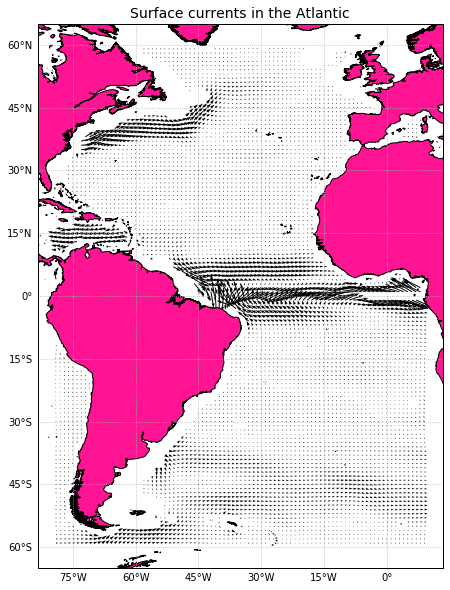

In [89]:
#Plot of velocities with map
colormap='RdPu'
proj=ccrs.PlateCarree()            
#features
land_10m=cfeature.NaturalEarthFeature(category='physical',
                            name='land',
                            scale='10m',
                            edgecolor='k',
                            facecolor='deeppink')

fig=plt.figure(figsize=(12,10))
ax=plt.axes(projection=proj)
gl1=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 10, 'color': 'black'}
gl1.ylabel_style = {'size': 10, 'color': 'black'}


#adding features
ax.add_feature(land_10m)
#adding the velocity vector
ax.quiver(Long,Latg,u_grid[time_index,:,:],v_grid[time_index,:,:])
ax.set_title('Surface currents in the Atlantic',fontsize=14)

#Maximum velocity
print('Maximum velocity : ')
print(str(np.max(np.sqrt(u_grid**2 +v_grid**2))//0.001/10)+' cm/s')


In [90]:
%%latex
Pour calculer l'élévation correspondant aux courants calculés précédemment, nous supposons que l'océan est à l'équilibre géostrophique, et de masse volumique constante. Nous obtenons alors :
\begin{equation*}
v=\frac{g}{f}\partial_x \eta\\
u=-\frac{g}{f}\partial_y \eta
\end{equation*}

En intégrant la première équation, on obtient :
\begin{equation*}
\eta(x,y)=\int_{x_0}^{x}\frac{f}{g}vdx+C(y)\\
\end{equation*}

En dérivant cette expression par rapport à y, et en substituant $\partial_y\eta$ :
\begin{equation*}
\frac{dC}{dy}=-\frac{f}{g}u - \partial_y\left(\int_{x_0}^x\frac{f}{g}vdx\right)\\
\Rightarrow C(y)=\int_{y_0}^y\left(-\frac{f}{g}u - \partial_y\underbrace{\int_{x_0}^x \frac{f}{g}vdx}_{\text{eta_x}} \right) dy
\end{equation*}

Informatiquement, les vitesses $u$ et $v$ sont disposées sur la deuxième grille (grille dorée), et nous pouvons donc considérer la valeur du champ de vitesse comme constant sur une maille de la première grille (maille bleue).
Nous allons donc nous servir de l'ancienne grille pour définir $dx$ et $dy$.

\begin{equation*}
\end{equation*}

Malheureusement, cette technique ne donnait pas de résultat très satisfaisant... 
Une erreur d'intégration avait été faite, mais donnait finalement des résultats plus réalistes. Nous avons donc décidé de garder cette méthode.
Nous avons considéré que :
\begin{equation*}
\eta(x,y)=\int_{x_0}^x\frac{f}{g}vdx - \int_{y_0}^y \frac{f}{g}udy +cste\\
\end{equation*}

La constante sera choisie de telle manière que la valeur moyenne de $\eta$ sera nulle. 

<IPython.core.display.Latex object>

In [67]:
# Calcul des intégrandes
dx2=Rt*np.cos(Latg[:,:]*np.pi/180)*0.5*((Longitude[1:,1:]+Longitude[:-1,1:])-(Longitude[1:,:-1]+Longitude[:-1,:-1]))*np.pi/180
#dx2 correspond à la distance entre deux longitudes de la grille initiale, aux latitudes de la seconde grille

dy2=Rt*(Latitude[1:,:-1]-Latitude[:-1,:-1])*np.pi/180 # On ne prend pas le dernier élément qui correspond à la 
                                                      # frontière Est car toute la grille dy2 est décalée d'un 
                                                      # demi-degré en latitude par rapport à dy

#Paramètre de Coriolis                     
f2=2*omega*np.sin(Latg*np.pi/180)                     # Le paramètre de Coriolis est pris aux latitudes de la deuxième grille

#Integrands
deta_x=f2[:,:]/g*v_grid[time_index,:,:]*dx2
deta_y=-f2[:,:]/g*u_grid[time_index,:,:]*dy2


#Integrals
eta_x=np.nancumsum(deta_x,axis=1)
eta_x=eta_x-np.mean(eta_x)

eta_y=np.nancumsum(deta_y,axis=0)
eta_y=eta_y-np.mean(eta_y)

eta=100*(eta_x+eta_y)                      # Conversion to centimeters



Text(0.5, 1.0, 'Sea surface height contours (cm)')

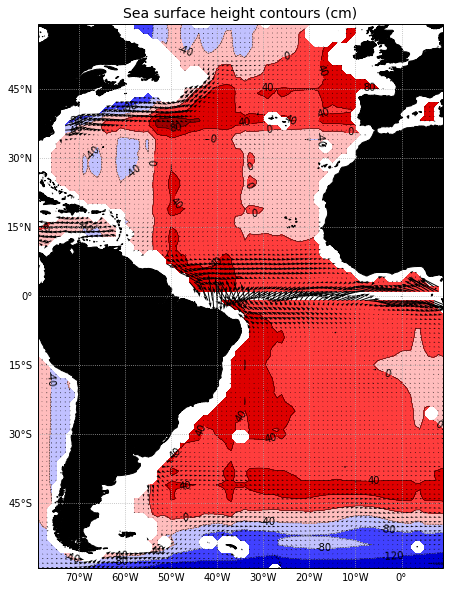

In [68]:
# Plot of velocities and sea surface anomaly
colormap='seismic'
proj=ccrs.PlateCarree()            
#features
land_10m=cfeature.NaturalEarthFeature(category='physical',
                            name='land',
                            scale='10m',
                            edgecolor='k',
                            facecolor='k')

#for plotting: find

#the plot

fig=plt.figure(figsize=(12,10))
ax=plt.axes(projection=proj)
gl1=ax.gridlines(linestyle=':',draw_labels=True)   #Add Gridlines
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 10, 'color': 'black'}
gl1.ylabel_style = {'size': 10, 'color': 'black'}


#adding features
ax.add_feature(land_10m)
#adding the velocity vector
ax.contourf(Long,Latg,eta,cmap=colormap)
CS=ax.contour(Long,Latg,eta,colors='k',linewidths=0.5)
plt.clabel(CS, fontsize=10, inline=True, fmt = '%1.0f')
ax.quiver(Long,Latg,u_grid[time_index,:,:],v_grid[time_index,:,:])
ax.set_title('Sea surface height contours (cm)',fontsize=14)


In [69]:
%%latex
La méthode utilisée somme du Sud vers le nord les intégrandes. La méthode "cumsum" utilisée entraîne un problème physique
où la hauteur d'eau "traverse" le Brésil. Ceci crée un gradient zonal de hauteur d'eau dans l'Atlantique Nord qui ne devrait 
pas exister, puisqu'aucun courant géostrophique ne lui est associé. Je ne vois pour l'instant pas comment résoudre ce problème.


<IPython.core.display.Latex object>